In [30]:
import numpy as np
import pandas as pd

import os
from PyPDF2 import PdfFileReader
import re

from collections import Counter
from collections import defaultdict

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
pdfFile = [file for file in os.listdir('data') if 'pdf' in file][0]

In [32]:

with open(os.path.join('data',pdfFile),'rb') as f:
    if f:
        ipdf = PdfFileReader(f)
        text = [p.extractText() for p in ipdf.pages]

In [33]:
text[0].replace('\n',' ')

'1  Dosar nr. 11/P/2014                                                                 Extras  R E C H I Z I T O R I U  -f  -   Ziua  05,  luna  aprilie,  anul  2019      Colonel  magistrat  , procuror militar,   în cadrul  Parchetului de pe       sus (având ca o   în contextul    din decembrie 1989   a      lipsirea de libertate a multor persoane,   distrugerea  unor bunuri de patrimoniu, pe întregul teritoriu al României),  privindu- i pe               Iliescu Ion ,    i, cercetat în stare de libertate pentru     penal,  cu aplicarea art. 5 Cp.,     Voiculescu Voican Gelu , fost viceprim-ministru al Guvernului  României      ,  cu aplicarea art.5  Cp.,  '

In [34]:
string = 'Spre deosebire de regimul dictatorial'
[tx for tx in text if string in tx][0]

'6  \n i prea pu\n\n\n\nextern ,\n\n  Noile raporturi interna\n\nPartidului Comunist al Uniunii Sovietice, Mihail Gorbaciov, venit la con\nducerea \npartidului în martie 1985, au complicat \ni mai mult situa\nia \ncomuniste. Politica de restructurare/reformare/reorganizare a sistemului \n perestroika\n \nglasnosti\n pe care noul lider de la Kremlin a ini\niat-o în Uniunea \n\ni asupra statelor din blocul comunist. \n \n\nBucure\nti i mai ales la dogmaticul secretar general al partidului. \n Spre deosebire de regimul dictatorial ceau\nist, regimurile comuniste din \n\nprecum Ungaria, Cehoslovacia \ni Polonia au început din deceniul al optu\n\n\n-a manifestat printr-o serie de concesii atât în \ndomeniul economic, spiritual cât \ni cel politic. Nu este lipsit de importan\n\n\nionat \ni alte partide decât partidele comuniste \ni care, chiar \n\n\n \napari\nia unor nuclee opozi\nioniste fa\n\nin a unor puncte \nde vedere diferite de cele oficiale \n\n-au putut cristaliza aripi reformatoare

notice that'[space]\n' marks the paragraphs

In [35]:
paragraphs = ' '.join(text).split('. \n')

In [36]:
paragraphs = [para.replace('\n','') for para in paragraphs ]

In [37]:
paragraphs[0]

'1  Dosar nr. 11/P/2014                                                               Extras R E C H I Z I T O R I U -f-  Ziua 05, luna aprilie, anul 2019    Colonel magistrat , procuror militar,  în cadrul Parchetului de pe   sus (având ca o în contextul  din decembrie 1989  a   lipsirea de libertate a multor persoane, distrugerea unor bunuri de patrimoniu, pe întregul teritoriu al României),  privindu-i pe             Iliescu Ion,  i, cercetat în stare de libertate pentru penal, cu aplicarea art. 5 Cp.,   Voiculescu Voican Gelu, fost viceprim-ministru al Guvernului României , cu aplicarea art.5 Cp.,  2    Gl. (rtr.) Rus Iosif,  fost comandant al , cercetat în stare , prev. de art. 439 lit'

In [38]:
def clean(str):
    lista = re.findall('[a-zA-Z.-]+', str)
    return ' '.join(lista).replace(' .','.')

In [39]:
pa = [clean(para) for para in paragraphs]

In [40]:
pa[0]

'Dosar nr. P Extras R E C H I Z I T O R I U -f- Ziua luna aprilie anul Colonel magistrat procuror militar n cadrul Parchetului de pe sus av nd ca o n contextul din decembrie a lipsirea de libertate a multor persoane distrugerea unor bunuri de patrimoniu pe ntregul teritoriu al Rom niei privindu-i pe Iliescu Ion i cercetat n stare de libertate pentru penal cu aplicarea art. Cp. Voiculescu Voican Gelu fost viceprim-ministru al Guvernului Rom niei cu aplicarea art. Cp. Gl. rtr. Rus Iosif fost comandant al cercetat n stare prev. de art. lit'

In [41]:
namePattern = "[A-Z]{1}[a-z]{1,30}[- ][A-Z]{1}[a-z]{1,30}[- ]{0,1}[A-Z]{1}[a-z]{1,30} | [A-Z]{1}[a-z]{1,30}[- ][A-Z]{1}[a-z]{1,30}"

In [42]:
re.findall(namePattern, pa[0])

[' Iliescu Ion', ' Voiculescu Voican', ' Guvernului Rom', ' Rus Iosif']

In [43]:
names =  [re.findall(namePattern, para) for para in pa if 
          len(re.findall(namePattern, para)) > 0]

In [44]:
names[:3]

[[' Iliescu Ion', ' Voiculescu Voican', ' Guvernului Rom', ' Rus Iosif'],
 [' Amiral Rtr',
  ' Dumitrescu Cico',
  ' Roman Petre',
  ' Guvernului Rom',
  ' Televiziunii Rom',
  ' Postelnicu Tudor',
  ' Toma Ioan'],
 [' Comitetului Central', ' Partidului Comunist']]

In [45]:
flat_list = [item for sublist in names for item in sublist]

In [46]:
set(flat_list)

{' Academiei Militare',
 ' Actualul Cod',
 ' Alba Iulia',
 ' Alexandru Ioan',
 ' Amiral Rtr',
 ' Apoi Iliescu',
 ' Arad Cetateexpunere',
 ' Arad Uzinelor',
 ' Armatei Ministerului',
 ' Astfel Iliescu',
 ' Avioane Craiova',
 ' Biblioteca Palatul',
 ' Bibliotecii Centrale',
 ' Brucan Silviu',
 ' Bucur La',
 ' Bucure Ceauilor',
 ' Bulevard Comitetul',
 ' Calea Girocului',
 ' Casa Sc',
 ' Cazul Otopeni',
 ' Ceauescu Nicolae',
 ' Ceauescu Nicolaei',
 ' Century Dictionary',
 ' Cercetarea Evenimentelor',
 ' Chambers Twentieth',
 ' Cico Emil',
 ' Cluj-Napoca',
 ' Cod Penal',
 ' Cod Penalgenocid',
 ' Codul Penal',
 ' Codul Penalacesta',
 ' Comandament La',
 ' Comandament Militar',
 ' Comandamentul Militar',
 ' Comandamentului In',
 ' Comandamentului Militar',
 ' Comisii Senatoriale',
 ' Comitetul Central',
 ' Comitetului Central',
 ' Comitetului Judeean',
 ' Comitetului Municipal',
 ' Comitetului Politic',
 ' Conform Codului',
 ' Consiliul Militar',
 ' Consiliul Popular',
 ' Consiliului Militar

In [47]:
itemNames = [' Alexandru Ioan', ' Brucan Silviu', ' Ceauescu Nicolae', ' Ceauescu Nicolaei', ' Cico Emil',
' Dumitrescu Cico', ' Dumitrescu Emil', ' Dumitrescu Ticu', ' Eftimescu Nicolae',  ' Emil Prin',
' Gabrielescu Valentin',' Gelu Voican', ' Hortopan Ion',
' Iliescu Ion', ' Inculpatul Dumitrescu', ' Inculpatul Voiculescu', ' Ion Iliescu', ' Iosif Rus',
' Mihail Gorbaciov', ' Milea Vasile', ' Militaru Nicolae', ' Mocanu Mircea', ' Neagoe Marin',
 ' Nicolae Ceauremedierea', ' Nicolae Milea', ' Nicolae Tudor', ' Postelnicu Tudor', ' Roman Petre', ' Rus Iosif',
 ' Toma Ioan', ' Tudor Postelnicu',   
' Viorel Toma', ' Vlad Iulian',' Vladimir Volkoff', ' Voican Gelu', ' Voican Voiculescu', ' Voiculescu Gelu',
 ' Voiculescu Voican',' Voinea Dan', ' Warde Barton', 'Dumitrescu Cico Emil ', 'Rtr Rus Iosif ',
'Voiculescu Voican Gelu ']

In [48]:
namesDict ={' Alexandru Ioan':'Alexandru Ioan', ' Brucan Silviu':'Brucan Silviu',
' Ceauescu Nicolae':'Ceausescu Nicolae', ' Ceauescu Nicolaei':'Ceausescu Nicolae',
' Cico Emil':'Dumitrescu Cico Emil', ' Dumitrescu Cico':'Dumitrescu Cico Emil',
' Dumitrescu Emil':'Dumitrescu Cico Emil', ' Dumitrescu Ticu':'Dumitrescu Ticu', 
' Eftimescu Nicolae':'Eftimescu Nicolae', ' Emil Prin': 'Emil Prin',' Gabrielescu Valentin':'Gabrielescu Valentin',
' Gelu Voican':'Voiculescu Voican Gelu', ' Hortopan Ion': 'Hortopan Ion', ' Iliescu Ion':'Iliescu Ion', 
' Inculpatul Dumitrescu':'Dumitrescu Cico Emil', ' Inculpatul Voiculescu':'Voiculescu Voican Gelu',
' Ion Iliescu':'Iliescu Ion', ' Iosif Rus': 'Rus Iosif', ' Mihail Gorbaciov':'Mihail Gorbaciov', 
' Milea Vasile':'Milea Vasile', ' Militaru Nicolae':'Militaru Nicolae', ' Mocanu Mircea':'Mocanu Mircea', 
' Neagoe Marin':'Neagoe Marin', ' Nicolae Ceauremedierea' :'Ceausescu Nicolae', ' Nicolae Milea':'Milea Vasile', 
' Nicolae Tudor':'Nicolae Tudor', ' Postelnicu Tudor':'Postelnicu Tudor',' Roman Petre':'Roman Petre',
' Rus Iosif':'Rus Iosif', ' Toma Ioan':'Toma Ioan', ' Tudor Postelnicu':'Postelnicu Tudor',
' Viorel Toma':'Viorel Toma', ' Vlad Iulian':'Vlad Iulian',' Vladimir Volkoff':'Vladimir Volkoff', 
' Voican Gelu':'Voiculescu Voican Gelu', ' Voican Voiculescu':'Voiculescu Voican Gelu',
' Voiculescu Gelu':'Voiculescu Voican Gelu', ' Voiculescu Voican':'Voiculescu Voican Gelu',
' Voinea Dan':'Voinea Dan', 'Dumitrescu Cico Emil ':'Dumitrescu Cico Emil', 'Rtr Rus Iosif ':'Rus Iosif',
'Voiculescu Voican Gelu ':'Voiculescu Voican Gelu'}

In [49]:
cleanNames = []
for sublist in names:
    interim = []
    for elem in sublist:
        if elem in namesDict:
            interim.append(namesDict[elem])
    interim = list(set(interim))
    if len(interim) > 1:
        cleanNames.append(interim)

In [50]:
cleanNames[:3]

[['Rus Iosif', 'Voiculescu Voican Gelu', 'Iliescu Ion'],
 ['Roman Petre', 'Toma Ioan', 'Postelnicu Tudor', 'Dumitrescu Cico Emil'],
 ['Ceausescu Nicolae', 'Mihail Gorbaciov']]

In [51]:
co_occurences = defaultdict(Counter)
for tags in cleanNames:
    for key in tags:
        co_occurences[key].update(tags)
unique_tags = sorted(co_occurences)

In [52]:
print( co_occurences)


defaultdict(<class 'collections.Counter'>, {'Rus Iosif': Counter({'Rus Iosif': 2, 'Voiculescu Voican Gelu': 2, 'Iliescu Ion': 2}), 'Voiculescu Voican Gelu': Counter({'Voiculescu Voican Gelu': 16, 'Iliescu Ion': 12, 'Militaru Nicolae': 6, 'Brucan Silviu': 5, 'Rus Iosif': 2, 'Roman Petre': 2, 'Vlad Iulian': 2, 'Postelnicu Tudor': 1}), 'Iliescu Ion': Counter({'Iliescu Ion': 21, 'Voiculescu Voican Gelu': 12, 'Militaru Nicolae': 9, 'Dumitrescu Cico Emil': 5, 'Brucan Silviu': 5, 'Roman Petre': 3, 'Rus Iosif': 2, 'Vlad Iulian': 2, 'Nicolae Tudor': 1, 'Milea Vasile': 1, 'Postelnicu Tudor': 1, 'Emil Prin': 1}), 'Roman Petre': Counter({'Roman Petre': 5, 'Militaru Nicolae': 4, 'Dumitrescu Cico Emil': 3, 'Iliescu Ion': 3, 'Voiculescu Voican Gelu': 2, 'Brucan Silviu': 2, 'Toma Ioan': 1, 'Postelnicu Tudor': 1, 'Vlad Iulian': 1, 'Nicolae Tudor': 1}), 'Toma Ioan': Counter({'Toma Ioan': 3, 'Postelnicu Tudor': 2, 'Roman Petre': 1, 'Dumitrescu Cico Emil': 1, 'Viorel Toma': 1}), 'Postelnicu Tudor': Counte

In [53]:
print( unique_tags)

['Brucan Silviu', 'Ceausescu Nicolae', 'Dumitrescu Cico Emil', 'Dumitrescu Ticu', 'Eftimescu Nicolae', 'Emil Prin', 'Gabrielescu Valentin', 'Hortopan Ion', 'Iliescu Ion', 'Mihail Gorbaciov', 'Milea Vasile', 'Militaru Nicolae', 'Mocanu Mircea', 'Nicolae Tudor', 'Postelnicu Tudor', 'Roman Petre', 'Rus Iosif', 'Toma Ioan', 'Viorel Toma', 'Vlad Iulian', 'Voiculescu Voican Gelu']


In [63]:
df = pd.DataFrame(co_occurences).fillna(0)
df.values[[np.arange(df.shape[0])]*2] = 0

In [64]:
df

,Brucan Silviu,Ceausescu Nicolae,Dumitrescu Cico Emil,Dumitrescu Ticu,Eftimescu Nicolae,Emil Prin,Gabrielescu Valentin,Hortopan Ion,Iliescu Ion,Mihail Gorbaciov,...,Militaru Nicolae,Mocanu Mircea,Nicolae Tudor,Postelnicu Tudor,Roman Petre,Rus Iosif,Toma Ioan,Viorel Toma,Vlad Iulian,Voiculescu Voican Gelu
Brucan Silviu,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0,0.0,...,5.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,5.0
Ceausescu Nicolae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dumitrescu Cico Emil,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,...,6.0,0.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0
Dumitrescu Ticu,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eftimescu Nicolae,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Emil Prin,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gabrielescu Valentin,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hortopan Ion,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Iliescu Ion,5.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,9.0,0.0,1.0,1.0,3.0,2.0,0.0,0.0,2.0,12.0
Mihail Gorbaciov,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df.drop(['Ceausescu Nicolae','Mihail Gorbaciov'], axis=1, inplace=True)
df.drop(['Ceausescu Nicolae','Mihail Gorbaciov'], axis=0, inplace=True)

In [76]:
graph = nx.from_numpy_matrix(df.values)
graph = nx.relabel_nodes(graph, dict(enumerate(df.columns)))

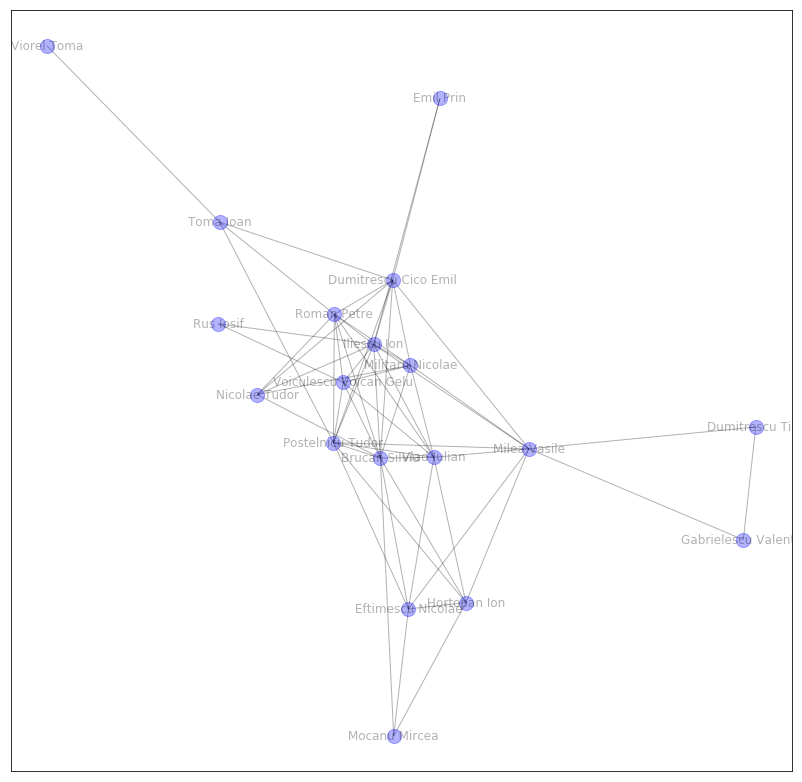

In [89]:
plt.figure(figsize=(14,14))
nx.draw_networkx(graph, pos=nx.spring_layout(graph, scale=5), arrows=False, node_size=200, with_labels=True, node_color='blue', alpha=0.3) 
plt.savefig(os.path.join('images','image.png'))
plt.show()


In [81]:
pagerank = nx.pagerank(graph)

In [88]:
rankDF = pd.DataFrame(pagerank,index=[0]).T
rankDF.columns = ['Rank']
rankDF.sort_values(by='Rank',ascending=False)

,Rank
Iliescu Ion,0.140757
Militaru Nicolae,0.116794
Voiculescu Voican Gelu,0.099276
Brucan Silviu,0.089093
Dumitrescu Cico Emil,0.075359
Roman Petre,0.065923
Vlad Iulian,0.059771
Milea Vasile,0.057586
Postelnicu Tudor,0.054589
Eftimescu Nicolae,0.037370
